In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from data_utils import *
from data_utils import *
from encoder import *
from decoder import *
from inr_wrapper import *

In [2]:
init_cond = np.load('ns_2d_initialcond.npy')
sol = np.load('ns_2d_solutions.npy')
time = np.load('ns_2d_time.npy')

In [3]:
print('Initial Condition shape:', init_cond.shape)
print('Solution shape:', sol.shape)
print('Time shape:', time.shape)
nx = ny = init_cond.shape[1]

Initial Condition shape: (40, 128, 128)
Solution shape: (40, 128, 128, 40)
Time shape: (40,)


In [4]:
sample_idx = np.random.randint(0, init_cond.shape[0])
true_field = np.concatenate((np.expand_dims(init_cond[sample_idx,:,:], axis=0), np.transpose(sol[sample_idx, :, :, :],(2,0,1))), axis=0)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
train_loader, val_loader, test_loader = get_dataloader(
    sol_field=torch.tensor(sol, dtype=torch.float32),
    initial_cond=torch.tensor(init_cond, dtype=torch.float32),
    time=torch.tensor(time, dtype=torch.float32),
    batch_size=16,
    shuffle=True
)

In [7]:
#hyperparameters
syn_features = [2,16,32,64,128,1]
mod_features = [int(2*i) for i in syn_features[:-1]]
encoder_channels = [1,16,32,32,64,128]
exp_latent_size = 256 ; imp_latent_size = 256
num_epochs = 500 ; sampled_pts = 2048

In [8]:
# Initialize Model
dataloader_size = len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset)
print(f"Dataloader size: {dataloader_size} samples")
cnn_encoder = CNNEncoderBlock(channels=encoder_channels, latent_size=exp_latent_size).to(device)
synthesis_net = SynthesisNet(features=syn_features).to(device)
modulation_net = ModulationNet(features=mod_features, z_emb_size= int(imp_latent_size +exp_latent_size)).to(device)
model = INRWrapper(synthesis_net, modulation_net, cnn_encoder, dataloader_size, imp_latent_size, True, True).to(device)

Dataloader size: 1640 samples


In [9]:
checkpoint = torch.load('saved_wts/inr_mixed_256.pth', map_location=device)
model.load_state_dict(checkpoint)

/tmp/ipykernel_10681/3657450914.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('saved_wts/inr_mixed_256.pth', map_location=device)


<All keys matched successfully>

In [10]:
true_field_tensor = torch.tensor(true_field, device=device)
print(true_field_tensor.shape)
pred_field, _ = inr_inference(model, true_field_tensor.unsqueeze(1), 200, True, True, device)
print(pred_field.shape)

torch.Size([41, 128, 128])
ITO Step 25/200, Loss: 0.002161
ITO Step 50/200, Loss: 0.001739
ITO Step 75/200, Loss: 0.001521
ITO Step 100/200, Loss: 0.001361
ITO Step 125/200, Loss: 0.001233
ITO Step 150/200, Loss: 0.001126
ITO Step 175/200, Loss: 0.001032
ITO Step 200/200, Loss: 0.000946
(41, 128, 128)


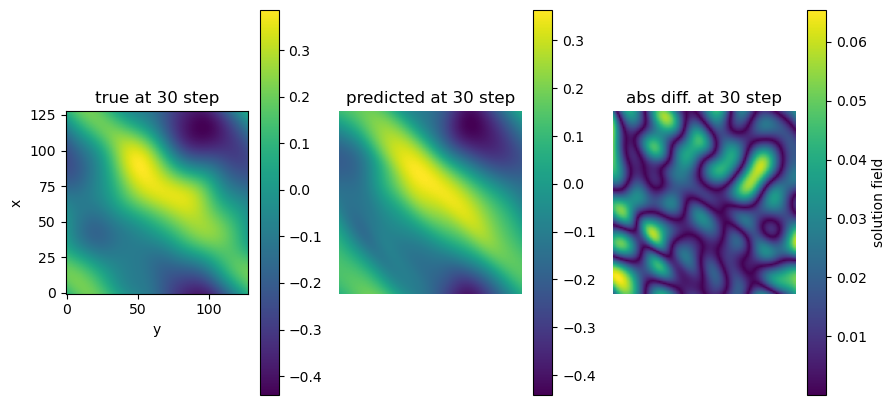

In [20]:
idx = 30
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(true_field[idx,:,:], origin='lower')
plt.xlabel("y")
plt.ylabel("x")
plt.title(f"true at {idx} step")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(pred_field[idx,:,:], origin='lower')
plt.title(f"predicted at {idx} step")
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
diff  = np.abs(pred_field[idx,:,:] - true_field[idx,:,:])
plt.imshow(diff, origin='lower')
plt.title(f"abs diff. at {idx} step")
plt.colorbar(label="solution field")
plt.axis('off')
plt.show()

In [21]:
true_sol = true_field[0,:,:]
pred_sol = pred_field[0,:,:]
nx, ny = true_sol.shape

#true solution fft
true_fft2 = np.fft.fft2(true_sol)
true_fft2_shifted = np.fft.fftshift(true_fft2)
true_energy_2d = np.abs(true_fft2_shifted)**2 

# pred solution fft
pred_fft2 = np.fft.fft2(pred_sol)
pred_fft2_shifted = np.fft.fftshift(pred_fft2)
pred_energy_2d = np.abs(pred_fft2_shifted)**2

# freq space
kx = np.fft.fftfreq(nx) * nx
ky = np.fft.fftfreq(ny) * ny
kx, ky = np.meshgrid(np.fft.fftshift(kx), np.fft.fftshift(ky), indexing='ij')


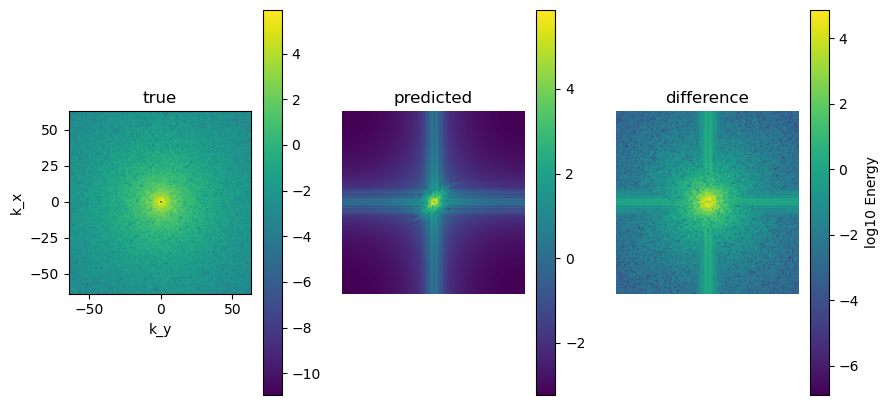

In [ ]:
# spectral space plot
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(np.log10(true_energy_2d + 1e-12), extent=[ky.min(), ky.max(), kx.min(), kx.max()], origin='lower')
plt.xlabel("k_y")
plt.ylabel("k_x")
plt.title("true")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log10(pred_energy_2d + 1e-12), extent=[ky.min(), ky.max(), kx.min(), kx.max()], origin='lower')
plt.title("predicted")
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
diff_energy_2d  = np.abs(pred_energy_2d - true_energy_2d)
plt.imshow(np.log10(diff_energy_2d + 1e-12), extent=[ky.min(), ky.max(), kx.min(), kx.max()], origin='lower')
plt.title("difference")
plt.colorbar(label="log10 Energy")
plt.axis('off')
plt.show()

In [24]:
# compute energy spectrum
k_mag = np.sqrt(kx**2 + ky**2)
k_max = int(np.max(k_mag))

# Bin energy by integer wavenumber radius
true_E_k = np.zeros(k_max + 1)
pred_E_k = np.zeros(k_max + 1)
true_count = np.zeros(k_max + 1)
pred_count = np.zeros(k_max + 1)

for i in range(nx):
    for j in range(ny):
        k_int = int(k_mag[i, j])
        true_E_k[k_int] += true_energy_2d[i, j]
        pred_E_k[k_int] += pred_energy_2d[i,j]
        true_count[k_int] += 1
        pred_count[k_int] += 1

# Normalize by number of modes in shell
pred_count[pred_count == 0] = 1 ; true_count[true_count == 0] = 1
true_E_k /= true_count
pred_E_k /= pred_count

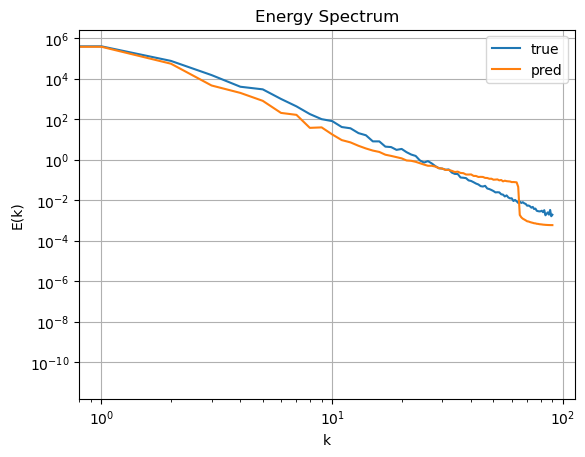

In [25]:
plt.figure()
plt.loglog(true_E_k, label='true')
plt.loglog(pred_E_k, label='pred')
plt.xlabel("k")
plt.ylabel("E(k)")
plt.title("Energy Spectrum")
plt.grid(True)
plt.legend()
plt.show()